# BIG_GAN_DEEP_128

[BIG_GAN_Model](https://openreview.net/forum?id=B1xsqj09Fm)

[BIG_GAN_Github](https://github.com/huggingface/pytorch-pretrained-BigGAN)
  
[BIG_GAN中文心得](https://medium.com/@xiaosean5408/biggan%E7%B0%A1%E4%BB%8B-large-scale-gan-training-for-high-fidelity-natural-image-synthesis-df349a5f811c)

## Load big gan pretrain model

In [4]:
#!pip install pytorch_pretrained_biggan

import numpy as np, pandas as pd, os
import os, torch, gc
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_pretrained_biggan import BigGAN, truncated_noise_sample

# LOAD PRETRAINED BIGGAN-DEEP-128
model = BigGAN.from_pretrained('biggan-deep-128')

## Latent walk  

[list](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)  
這裡試了從狗到貓的latent walk  

In [2]:
COLS = 10
ROWS = 10
truncation = 0.5
class_vector = np.zeros((ROWS*COLS,1000),dtype=np.float32)
noise_vector = np.zeros((ROWS*COLS,128),dtype=np.float32)

for j in range(ROWS):
    
    # CHANGE THE FOLLOWING TWO LINES TO CONTROL WHAT CLASS MORPHS TO WHAT CLASS
    #################
    # DOGS ARE CLASSES 151 THRU 281, CATS ARE 281 THRU 294
    # CATEGORY LIST HERE: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
    class_vector[j*COLS,np.random.randint(151,281)]=1 # START CLASS
    class_vector[(j+1)*COLS-1,np.random.randint(281,294)]=1 # END CLASS   
    #################
    
    step = class_vector[(j+1)*COLS-1,] - class_vector[j*COLS,]
    for k in range(1,COLS-1):
        class_vector[j*COLS+k,] = class_vector[j*COLS,] + (k/(COLS-1))*step
    noise_vector[j*COLS,:] = truncated_noise_sample(truncation=truncation, batch_size=1)
    noise_vector[(j+1)*COLS-1,:] = truncated_noise_sample(truncation=truncation, batch_size=1)
    step = noise_vector[(j+1)*COLS-1,]-noise_vector[j*COLS,]
    for k in range(1,COLS-1):
        noise_vector[j*COLS+k,] = noise_vector[j*COLS,] + (k/(COLS-1))*step

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')
output = output.numpy().transpose(0, 2, 3, 1)

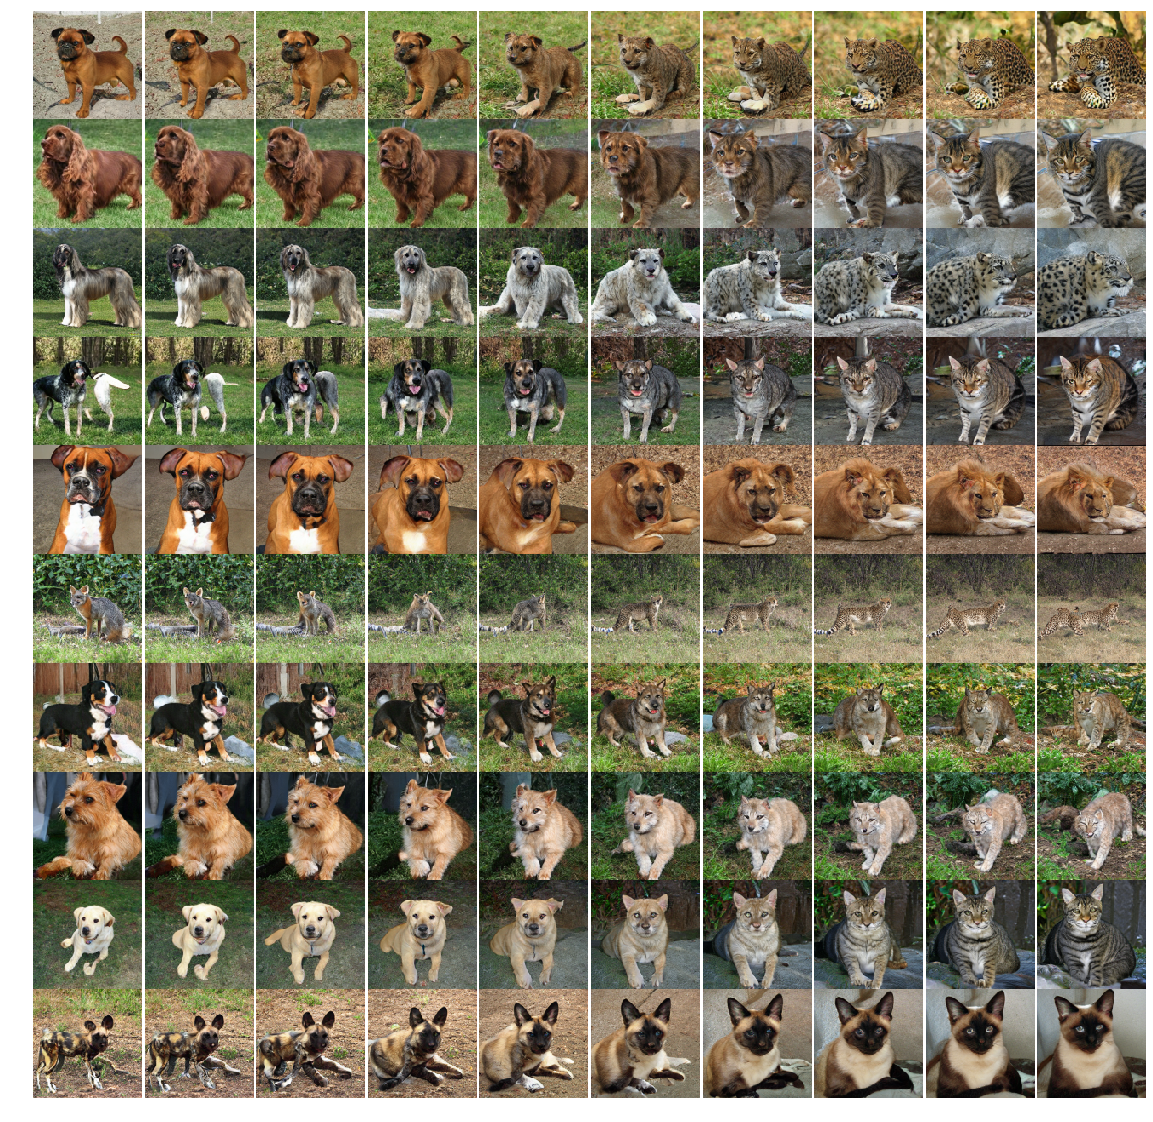

In [3]:
# DISPLAY LATENT WALK
plt.figure(figsize=(int(2*COLS),int(2*ROWS)))
plt.subplots_adjust(hspace=0,wspace=0)
for k in range(ROWS*COLS):
    plt.subplot(ROWS,COLS,k+1)
    img = Image.fromarray( ((output[k,]+1.)/2.*255).astype('uint8') )
    plt.axis('off')
    plt.imshow(img)
plt.show(img)